## Dependencies

In [9]:
!pip install sentence-transformers -q

     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 5.3 MB 59.4 MB/s 
     |████████████████████████████████| 1.3 MB 55.9 MB/s 
     |████████████████████████████████| 163 kB 71.0 MB/s 
     |████████████████████████████████| 7.6 MB 61.9 MB/s 


In [37]:
!pip install joblib==1.1.0 -q

In [36]:
!pip install bertopic -q

     |████████████████████████████████| 306 kB 29.7 MB/s 


In [12]:
!pip install wordcloud -q

In [13]:
!pip install numba --upgrade -q

In [14]:
!pip install spacy-transformers -q

     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 58.5 MB/s 
     |████████████████████████████████| 4.7 MB 45.7 MB/s 
     |████████████████████████████████| 6.6 MB 60.0 MB/s 


In [15]:
!python -m spacy download en_core_web_trf -q

     |████████████████████████████████| 460.3 MB 27 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
%cd /content/
!git clone https://github.com/tilekchubakov/bbc_news_corpus.git

/content
fatal: destination path 'bbc_news_corpus' already exists and is not an empty directory.


In [18]:
import spacy
from spacy.lang.en import English
from sentence_transformers import SentenceTransformer ,  util
import torch

## Read in data

In [19]:
classes = ['business', 'entertainment', 'politics' ,'sport', 'tech']

label_codes = dict()    

for i in range(len(classes)):
    label_codes[classes[i]] = i
    
print(label_codes)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [20]:
import pandas as pd
import glob

data_root_path = "/content/bbc_news_corpus/data/bbc/"
text_data = []

for cls in classes:
  text_files = glob.glob(data_root_path + cls + "/*.txt")

  for file in text_files:
    with open(file, encoding='latin1') as f:
      # print(file)
      text = f.read()
      text_data.append((text, cls))

df = pd.DataFrame(text_data, columns=['text', 'label'])

In [21]:
df['text_len'] = df['text'].str.len()
df

,text,label,text_len
0,US firm pulls out of Iraq\n\nA US company has ...,business,1595
1,Dollar hits new low versus euro\n\nThe US doll...,business,1167
2,Karachi stocks hit historic high\n\nThe Karach...,business,3413
3,US trade gap hits record in 2004\n\nThe gap be...,business,1954
4,Oil prices reach three-month low\n\nOil prices...,business,2860
...,...,...,...
2220,Search sites get closer to users\n\nSearch sit...,tech,3512
2221,Players sought for $1m prize\n\nUK gamers are ...,tech,2832
2222,Mobile multimedia slow to catch on\n\nThere is...,tech,3887
2223,Online commons to spark debate\n\nOnline commu...,tech,3706


In [22]:
df['gold_label'] = df['label'].map(label_codes)
df

,text,label,text_len,gold_label
0,US firm pulls out of Iraq\n\nA US company has ...,business,1595,0
1,Dollar hits new low versus euro\n\nThe US doll...,business,1167,0
2,Karachi stocks hit historic high\n\nThe Karach...,business,3413,0
3,US trade gap hits record in 2004\n\nThe gap be...,business,1954,0
4,Oil prices reach three-month low\n\nOil prices...,business,2860,0
...,...,...,...,...
2220,Search sites get closer to users\n\nSearch sit...,tech,3512,4
2221,Players sought for $1m prize\n\nUK gamers are ...,tech,2832,4
2222,Mobile multimedia slow to catch on\n\nThere is...,tech,3887,4
2223,Online commons to spark debate\n\nOnline commu...,tech,3706,4


## Data exploration

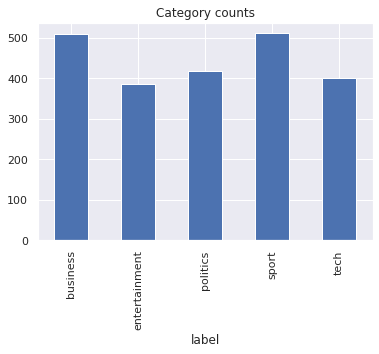

In [100]:
df_gb = df.groupby(['label']).size()
df_gb.plot(kind = 'bar', title='Category counts')

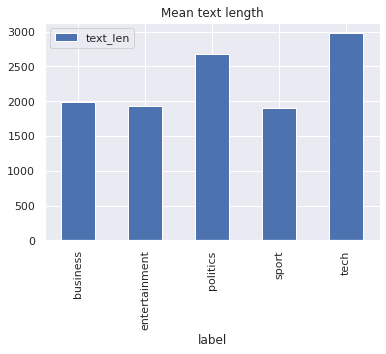

In [103]:
df_gb = df[['label','text_len']].groupby(['label']).mean()
df_gb.plot(kind = 'bar', title='Mean text length')

In [23]:
import re

# clean up text, removing urls, punctuation, etc.
def clean_word(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    text = text.replace(' ', '')
    
    return text.lower()

### Remove the stopwords and common top frequency words

In [24]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
# Get the list of top 100 most frequent words for each category
from nltk.tokenize import word_tokenize
from collections import Counter

stop_words = set(stopwords.words('english'))

word_lists = dict()
top_freq = dict()

top_K = 100

for cls in classes:
    cls_df = df[df.label == cls]
    whole_text = " ".join(cls_df['text'].tolist())
    words = word_tokenize(whole_text)
    words = list(map(clean_word, words))
    
    filtered_words = filter(lambda w: w not in stop_words, words)
    word_counter = Counter(filtered_words)   
    
    word_lists[cls] = filtered_words
    top_freq[cls] = set([w[0] for w in word_counter.most_common(top_K)])

In [26]:
# Get the intersection of top frequency words accross categories

common_top_freq = top_freq[classes[0]].copy()

for i in range(1, len(classes)):
    common_top_freq = common_top_freq.intersection(top_freq[classes[i]])
    
common_top_freq

{'',
 'also',
 'could',
 'first',
 'last',
 'made',
 'new',
 'one',
 'said',
 'time',
 'two',
 'us',
 'world',
 'would',
 'year',
 'years'}

In [27]:
# add the common top frequency words to the stopword list

stop_words.update(list(common_top_freq))

### Word cloud

<Figure size 432x288 with 0 Axes>

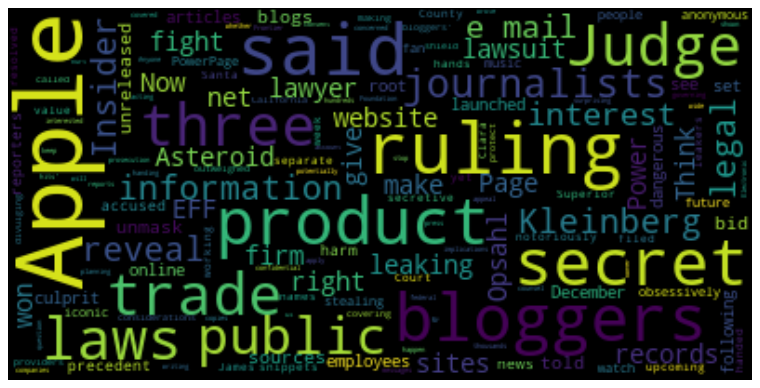

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud

whole_text = " ".join(df['text'].tolist())
words = word_tokenize(whole_text)
words = list(map(clean_word, words))

filtered_words = filter(lambda w: w not in stop_words, words)
filtered_text = " ".join(filtered_words)
   
wordcloud = WordCloud().generate(filtered_text)

wordcloud = WordCloud(max_font_size=50).generate(text)
plt.figure()
figure(figsize=(12, 8), dpi=80)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Document-level embeddings

In [29]:
# Load pregenerated embeddings

train_doc_embeddings = False

In [30]:
'''
Generate document-level embeddings using the Siamese BERT-Networks (https://arxiv.org/abs/1908.10084).
Document embeddings are created as the mean of sentence embeddings.

Use Spacy English pipeline to split documents into sentences.
'''

import pickle

if train_doc_embeddings:

  model = SentenceTransformer('stsb-bert-base')
  nlp = spacy.load("en_core_web_trf")

  doc_embeddings = []

  for ind, row in df.iterrows():
    text = row['text'].replace('\n\n', '.\n')
    doc = nlp(text)
    
    sentences = [sent.text.strip() for sent in doc.sents]

    sent_embeddings = list(model.encode(sentences, convert_to_tensor=True))
    doc_embed = torch.mean(torch.stack(sent_embeddings),dim=0)

    doc_embeddings.append(doc_embed)

  # save the generated embeddings to a file
  file = open('/content/bbc_news_corpus/data/bbc/doc_embeddings.pk', 'wb')
  pickle.dump(doc_embeddings, file)
  file.close()


In [31]:
import pickle

embed_file = open("/content/bbc_news_corpus/data/bbc/doc_embeddings.pk", "rb")
loaded_arr_doc_embeddings = pickle.load(embed_file)
embed_file.close()

print(len(loaded_arr_doc_embeddings))

# save embeddings as a list of numpy arrays
arr_dock_embeddings = [t.cpu().numpy() for t in loaded_arr_doc_embeddings]

2225


In [32]:
df['embed'] = arr_dock_embeddings

In [33]:
df.head()

,text,label,text_len,gold_label,embed
0,US firm pulls out of Iraq\n\nA US company has ...,business,1595,0,"[0.37530246, 0.19009963, 0.14128765, -0.137660..."
1,Dollar hits new low versus euro\n\nThe US doll...,business,1167,0,"[-0.34383252, 0.09862932, 0.13145328, 0.008406..."
2,Karachi stocks hit historic high\n\nThe Karach...,business,3413,0,"[-0.23945604, -0.20906864, 0.4775665, -0.07597..."
3,US trade gap hits record in 2004\n\nThe gap be...,business,1954,0,"[0.2546868, 0.10471103, 0.5662063, -0.31082472..."
4,Oil prices reach three-month low\n\nOil prices...,business,2860,0,"[-0.24192758, -0.37249509, -0.1495342, 0.13277..."


## Classification

A simple linear classifier with two layers on top of document-level embeddings.

In [29]:
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [30]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label_codes[label] for label in df['label']]       
        self.text_embed = [embed for embed in df['embed']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_embeds(self, idx):
        return self.text_embed[idx]

    def __getitem__(self, idx):

        batch_embeds = self.get_batch_embeds(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_embeds, batch_y

In [31]:
class TextClassifier(nn.Module):

    def __init__(self, dropout=0.3):

        super(TextClassifier, self).__init__()

        self.linear1 = nn.Linear(768, 768)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(768, len(classes))
        self.relu = nn.ReLU()

    def forward(self, input_embed):

        lin1_out = self.linear1(input_embed)        
        dropout_output = self.dropout(lin1_out)
        lin2_out = self.linear2(dropout_output)
        final_layer = self.relu(lin2_out)

        return final_layer

In [32]:
BATCH_SIZE = 2

In [33]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)
   
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
      
    criterion = nn.CrossEntropyLoss()
    
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()
            
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                train_input = train_input.to(device)
                
                output = model(train_input)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)
                    
                    output = model(val_input)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')                  

In [34]:
import numpy as np

np.random.seed(42)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [35]:
EPOCHS = 10
model = TextClassifier(dropout=0.1)
LR = 1e-5
              
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 890/890 [00:01<00:00, 615.97it/s]


Epochs: 1 | Train Loss:  0.607 | Train Accuracy:  0.788 | Val Loss:  0.455 | Val Accuracy:  0.865


100%|██████████| 890/890 [00:01<00:00, 611.29it/s]


Epochs: 2 | Train Loss:  0.346 | Train Accuracy:  0.931 | Val Loss:  0.287 | Val Accuracy:  0.905


100%|██████████| 890/890 [00:01<00:00, 625.67it/s]


Epochs: 3 | Train Loss:  0.220 | Train Accuracy:  0.944 | Val Loss:  0.202 | Val Accuracy:  0.923


100%|██████████| 890/890 [00:01<00:00, 620.22it/s]


Epochs: 4 | Train Loss:  0.155 | Train Accuracy:  0.953 | Val Loss:  0.153 | Val Accuracy:  0.946


100%|██████████| 890/890 [00:01<00:00, 637.16it/s]


Epochs: 5 | Train Loss:  0.118 | Train Accuracy:  0.959 | Val Loss:  0.124 | Val Accuracy:  0.946


100%|██████████| 890/890 [00:01<00:00, 632.33it/s]


Epochs: 6 | Train Loss:  0.095 | Train Accuracy:  0.966 | Val Loss:  0.109 | Val Accuracy:  0.946


100%|██████████| 890/890 [00:01<00:00, 633.70it/s]


Epochs: 7 | Train Loss:  0.079 | Train Accuracy:  0.970 | Val Loss:  0.095 | Val Accuracy:  0.950


100%|██████████| 890/890 [00:01<00:00, 637.23it/s]


Epochs: 8 | Train Loss:  0.068 | Train Accuracy:  0.974 | Val Loss:  0.085 | Val Accuracy:  0.950


100%|██████████| 890/890 [00:01<00:00, 626.42it/s]


Epochs: 9 | Train Loss:  0.060 | Train Accuracy:  0.974 | Val Loss:  0.076 | Val Accuracy:  0.964


100%|██████████| 890/890 [00:01<00:00, 624.40it/s]


Epochs: 10 | Train Loss:  0.054 | Train Accuracy:  0.977 | Val Loss:  0.071 | Val Accuracy:  0.973


In [36]:
def evaluate(model, test_data):

    testset = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    y_test = []
    y_pred = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              test_input = test_input.to(device)
              output = model(test_input)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              y_test.append(test_label.item())
              y_pred.append(output.argmax(dim=1).item())
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    return y_test, y_pred

In [37]:
y_test, y_pred = evaluate(model, df_test)

Test Accuracy:  0.982


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes))

               precision    recall  f1-score   support

     business       0.96      1.00      0.98        44
entertainment       1.00      0.97      0.99        35
     politics       1.00      0.95      0.98        43
        sport       0.98      1.00      0.99        59
         tech       0.98      0.98      0.98        42

     accuracy                           0.98       223
    macro avg       0.98      0.98      0.98       223
 weighted avg       0.98      0.98      0.98       223



## Topic modelling

In [38]:
from bertopic import BERTopic

docs = df['text'].tolist()

embedding_model = SentenceTransformer('stsb-bert-base')

topic_model = BERTopic(embedding_model=embedding_model, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/614 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/377 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2022-10-30 20:23:44,985 - BERTopic - Transformed documents to Embeddings
2022-10-30 20:24:04,799 - BERTopic - Reduced dimensionality
2022-10-30 20:24:05,016 - BERTopic - Clustered reduced embeddings


In [40]:
TOP_K = 5

freq = topic_model.get_topic_info()

freq.head(TOP_K)

,Topic,Count,Name
0,-1,115,-1_the_to_of_and
1,0,932,0_the_to_of_in
2,1,329,1_the_to_and_he
3,2,168,2_film_the_best_in
4,3,88,3_the_in_open_to


In [41]:
# Most frequent topic

topic_model.get_topic(0) 

[('the', 0.03459767146595769),
 ('to', 0.028492965751620605),
 ('of', 0.02612896539258344),
 ('in', 0.02470829848469653),
 ('and', 0.022096842838814842),
 ('said', 0.020168701841395582),
 ('that', 0.01711890678413174),
 ('for', 0.01645288670016358),
 ('on', 0.016282082492260038),
 ('mr', 0.01625331391247671)]

In [43]:
topic_model.visualize_topics()

In [48]:
topic_model.visualize_hierarchy()

In [49]:
topic_model.visualize_barchart(top_n_topics=TOP_K)

In [50]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [51]:
topic_model.get_topic(0)

[('the', 0.028581862050604933),
 ('to', 0.021640845926714586),
 ('of', 0.019342710088385184),
 ('in', 0.018048070448844527),
 ('and', 0.016227167619684586),
 ('said', 0.013492933411654346),
 ('that', 0.011583448172089799),
 ('for', 0.011214057399074027),
 ('is', 0.011017006169027236),
 ('on', 0.010939812177393784)]

In [52]:
topic_model.visualize_barchart(top_n_topics=TOP_K)

## Clustering

### K-Means clustering

In [53]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics.cluster import rand_score


costs = []
coef = []
scores = []

MAX_CLUSTERS = 20

for num_clusters in range(2, MAX_CLUSTERS+1):
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(arr_dock_embeddings)
    cluster_assignment = clustering_model.labels_

    costs.append(clustering_model.inertia_)    
    scores.append(rand_score(df['gold_label'].values, cluster_assignment))
    
    sil_coeff = silhouette_score(arr_dock_embeddings, clustering_model.labels_, metric='euclidean')
    coef.append(sil_coeff)

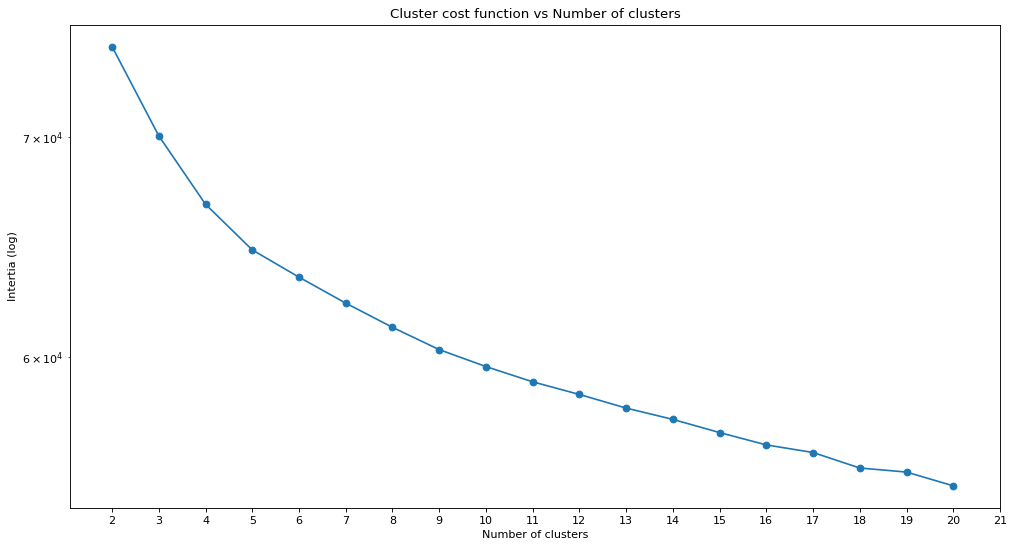

In [58]:
figure(figsize=(15, 8), dpi=80)

plt.plot(range(2, MAX_CLUSTERS+1), costs, linestyle = 'solid', marker='o')

plt.yscale('log')
plt.xticks(range(2, MAX_CLUSTERS+2))
plt.title("Cluster cost function vs Number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Intertia (log)")
plt.show()

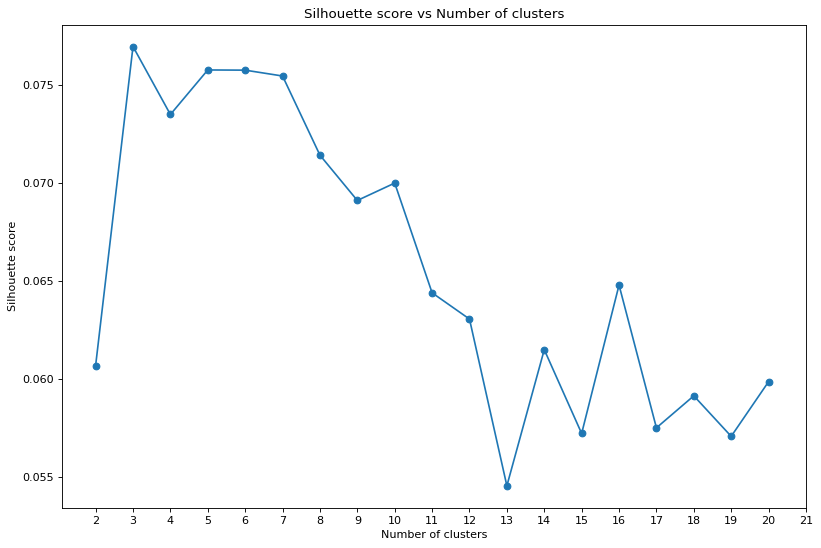

In [57]:
figure(figsize=(12, 8), dpi=80)

plt.plot(range(2, MAX_CLUSTERS+1), coef, linestyle = 'solid', marker='o')
plt.xticks(range(2, MAX_CLUSTERS+2))

plt.title("Silhouette score vs Number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

plt.show()

### Clustering evaluation vs gold labels

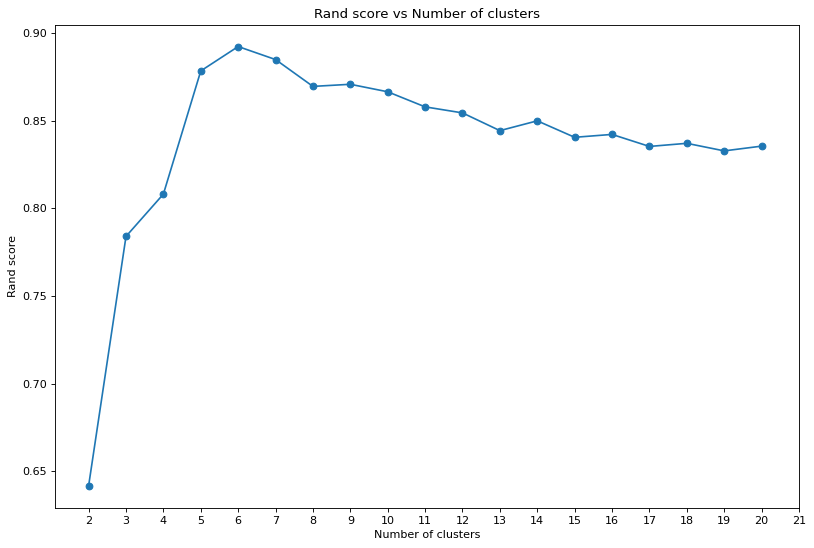

In [60]:
# Rand index (score) to benchmark againt gold labels
# Can only be used for final evaluation

figure(figsize=(12, 8), dpi=80)

plt.plot(range(2, MAX_CLUSTERS+1), scores, linestyle = 'solid', marker='o')
plt.xticks(range(2, MAX_CLUSTERS+2))

plt.title("Rand score vs Number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Rand score")

plt.show()

In [69]:
# Taking 5 for simplicity, actual numbers imply 6 is better

clustering_model = KMeans(n_clusters=5)
clustering_model.fit(arr_dock_embeddings)
cluster_assignment = clustering_model.labels_

In [70]:
df['cluster'] = cluster_assignment
df

,text,label,text_len,gold_label,embed,cluster
0,US firm pulls out of Iraq\n\nA US company has ...,business,1595,0,"[0.37530246, 0.19009963, 0.14128765, -0.137660...",4
1,Dollar hits new low versus euro\n\nThe US doll...,business,1167,0,"[-0.34383252, 0.09862932, 0.13145328, 0.008406...",2
2,Karachi stocks hit historic high\n\nThe Karach...,business,3413,0,"[-0.23945604, -0.20906864, 0.4775665, -0.07597...",2
3,US trade gap hits record in 2004\n\nThe gap be...,business,1954,0,"[0.2546868, 0.10471103, 0.5662063, -0.31082472...",0
4,Oil prices reach three-month low\n\nOil prices...,business,2860,0,"[-0.24192758, -0.37249509, -0.1495342, 0.13277...",2
...,...,...,...,...,...,...
2220,Search sites get closer to users\n\nSearch sit...,tech,3512,4,"[0.23221068, -0.021529138, 0.86181355, -0.0110...",3
2221,Players sought for $1m prize\n\nUK gamers are ...,tech,2832,4,"[-0.30694968, 0.014249663, 0.69383496, -0.0538...",3
2222,Mobile multimedia slow to catch on\n\nThere is...,tech,3887,4,"[-0.07038049, 0.17507508, 0.40153557, 0.024342...",3
2223,Online commons to spark debate\n\nOnline commu...,tech,3706,4,"[-0.29929647, 0.10597601, 0.12957771, 0.027883...",3


In [71]:
from sklearn.metrics.cluster import rand_score

print('Rand score: ', rand_score(df['gold_label'].values, cluster_assignment))

Rand score:  0.8784200953843667


### Cluster visualization

```
# This is formatted as code
```



In [72]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [73]:
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(arr_dock_embeddings)

pca_df = pd.DataFrame(pca_vectors)
pca_df['cluster'] = cluster_assignment
pca_df.columns = ['x1','x2','cluster']

In [74]:
tsne = TSNE(n_components=2)
tsne_vectors = tsne.fit_transform(pca_vectors)

tsne_df = pd.DataFrame(tsne_vectors)
tsne_df['cluster'] = cluster_assignment
tsne_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'PCA')

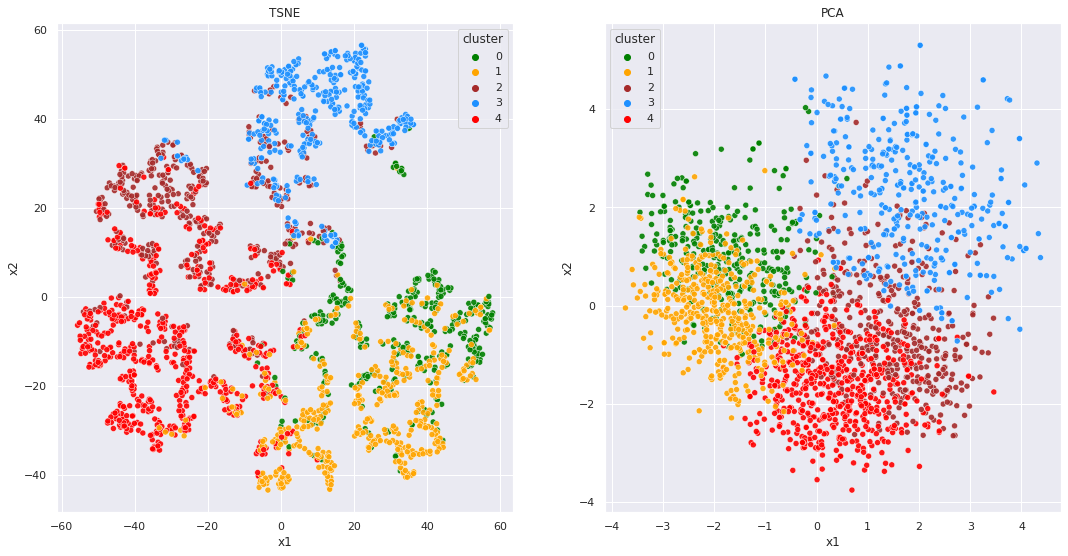

In [97]:
import seaborn as sns
sns.set()

fig, ax = plt.subplots(1, 2, figsize=(18,9))
sns.scatterplot(data=tsne_df, x='x1', y='x2', hue='cluster', palette=['green','orange','brown','dodgerblue','red'], legend="full", alpha=0.9, ax=ax[0])
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='cluster',  palette=['green','orange','brown','dodgerblue','red'], legend="full", alpha=0.9, ax=ax[1])

ax[0].set_title('TSNE')
ax[1].set_title('PCA')